In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [22]:
x = np.load("/home/eric.moreno/combined_heuristics_data_11k.npy")#, mmap_mode='r')

In [23]:
heuristic_model = "/home/katya.govorkova/gwak-paper-final-models/trained/model_heuristic.h5"
import torch.nn as nn
class BasedModel(nn.Module):
    def __init__(self):
        super(BasedModel, self).__init__()

        self.layer1 = nn.Linear(3, 1)
        self.layer2_1 = nn.Linear(1, 1)
        self.layer2_2 = nn.Linear(1, 1)
        self.layer2_3 = nn.Linear(1, 1)
        
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x1 = self.activation(self.layer1(x[:, :3]))
        # x2_1 = self.activation(self.layer2_1(x[:, 3:4]))
        # x2_2 = self.activation(self.layer2_2(x[:, 4:5]))
        # x2_3 = self.activation(self.layer2_3(x[:, 5:6]))
        x2_1 = self.activation(self.layer2_1(x[:, 3:4]))
        x2_2 = self.activation(self.layer2_1(x[:, 4:5]))
        x2_3 = self.activation(self.layer2_1(x[:, 5:6]))
        return x1 * x2_1 * x2_2 * x2_3

In [24]:
model = BasedModel()
model.load_state_dict(torch.load(heuristic_model, map_location=torch.device('cpu')))

<All keys matched successfully>

In [25]:
original_scores = x[:, -1]
heuristic_features = x[:, :-1]

In [26]:
model_input = torch.from_numpy(heuristic_features).float()
scored = model.forward(model_input).detach().numpy()

In [27]:
def sig_prob_function(evals, scale=40):
    sigmoid = lambda x: 1/(1+np.exp(-x))
    #sigmoid = lambda x: 1/(1+np.exp(-(x-0.3)))
    return 1-(sigmoid(scale * (evals-0.5)))
reweighting_factors = sig_prob_function(scored)

In [28]:
reweighted_scores = original_scores * reweighting_factors[:, 0]

In [29]:
sanity_filter = np.logical_and(original_scores > -50, original_scores < 0)
original_scores = original_scores[sanity_filter]
reweighted_scores = reweighted_scores[sanity_filter]

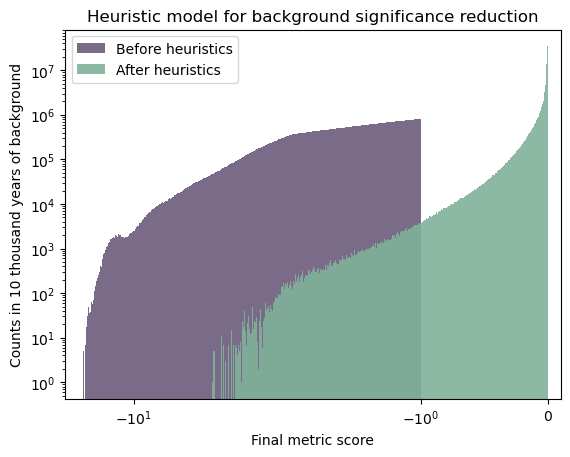

In [59]:
plt.style.use('default')
plt.hist(original_scores, bins=1500, color="#6c5b7b", alpha=0.9, label = 'Before heuristics')
plt.hist(reweighted_scores, bins=1500, color="#81b29a", alpha=0.9, label = 'After heuristics')
# plt.grid()
plt.yscale("log")
plt.xlabel("Final metric score")
plt.xscale("symlog")
plt.xlim((-20,0.1))
plt.ylabel("Counts in 10 thousand years of background")
plt.title("Heuristic model for background significance reduction")
plt.legend()
plt.savefig('plots/heuristics.png')